# Computational Biology Assignment 2
Victor Morland u1803398

## Task 1

$k^+ = 0.1$
$k^- = 0.4$

### a)

A timespan T = 5000s is used.

In [1]:
import numpy as np
import random
import math

def computeChannelSwitches(k_plus, k_minus):
    r = random.random()

    t_c = (1/k_plus) * math.log(1/r)
    t_o = (1/k_minus) * math.log(1/r)

    return t_c, t_o

In [2]:
timeInterval = 5000
currentTime = 0
k_plus = 0.1
k_minus = 0.4
closed = True
reaction_times = []

while currentTime <= timeInterval:
    t_c, t_o = computeChannelSwitches(k_plus, k_minus)

    if closed:
        reaction_times.append(currentTime + t_c)
        currentTime += t_c
    else:
        reaction_times.append(currentTime + t_o)
        currentTime += t_o
    closed = not closed

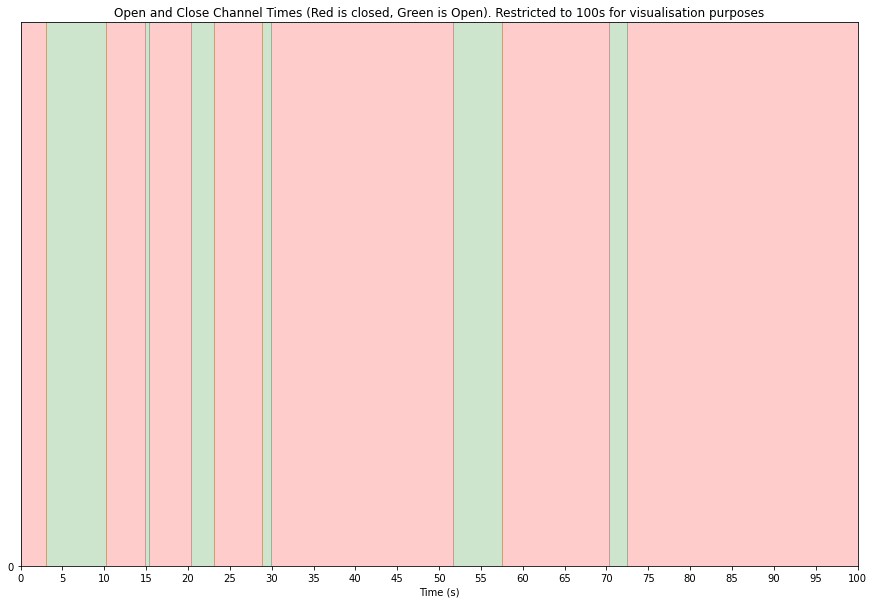

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.xlabel('Time (s)')
plt.title('Open and Close Channel Times (Red is closed, Green is Open). Restricted to 100s for visualisation purposes')
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, step=5))
plt.yticks(np.arange(0, 1, step=1))
plt.ylim(0, 1)

plt.axvspan(0, reaction_times[0], color='red', alpha=0.2)
colour = 'green'

for i in range(len(reaction_times)-1):
    plt.axvspan(reaction_times[i], reaction_times[i+1], color=colour, alpha=0.2)
    colour = 'green' if colour == 'red' else 'red'
    
plt.show()

### b)

$( \langle \tau_{O} \rangle = \frac{1}{k^{-}} = 2.5; \langle \tau_{C} \rangle = \frac{1}{k^{+}} = 10  )$

The calculated average open and closed dwell times are very similar to the expected times.

The calclated scores are as follows:

Avg Closed Dwell Time: 10.461 (3 d.p.)
Avg Open Dwell Time: 2.492 (3 d.p.)


In [21]:
opened = True
open_time_span = []
close_time_span = [reaction_times[0]]

for i in range(len(reaction_times) - 1):
    if opened:
        open_time_span.append(reaction_times[i+1] - reaction_times[i])
    else:
        close_time_span.append(reaction_times[i+1] - reaction_times[i])
    opened = not opened

if opened:
    open_time_span.append(timeInterval - reaction_times[-1])
else:
    close_time_span.append(timeInterval - reaction_times[-1])

print('Avg Open Time: {}'.format(sum(open_time_span)/len(open_time_span)))
print('Avg Closed Time: {}'.format(sum(close_time_span)/len(close_time_span)))

Avg Open Time: 2.4924540406915843
Avg Closed Time: 10.460913834956083


### c) Pr[C, [t, t + $\tau$] | C,t]

The theoretical value is $e^{k^+ \tau}$, which for $\tau = 10$ is $0.368$ (3 d.p).
The experimental value obtained is very close with $0.370$ (3 d.p).

In [22]:
def getProb(tau, time):
    currentTime = 0
    k_plus = 0.1
    k_minus = 0.4
    closed = True

    numOfCloses = 0
    numOfPredictedCloses = 0

    while currentTime < time:
        t_c, t_o = computeChannelSwitches(k_plus, k_minus)
        if closed:
            currentTime += t_c

            if tau < t_c:
                numOfPredictedCloses += 1
            numOfCloses += 1
            
        else:
            currentTime += t_o

        closed = not closed
    
    return numOfPredictedCloses/numOfCloses


In [23]:
print('Experimental Value: {}'.format(getProb(10, 100000)))
print('Theoretical Value: {}'.format((math.e) ** (-0.1*10)))

Experimental Value: 0.3695515638738852
Theoretical Value: 0.36787944117144233


### d) Formulating the transition matrix Q

We calculate the state distribution $\pi$ of states as stated below. Verifying it is correct.

In [25]:
k_plus = 0.1
k_minus = 0.4
deltaT = 1

theoryQ = np.array([[1-k_plus*deltaT, k_minus*deltaT],[k_plus*deltaT, 1-k_minus*deltaT]])
print('The transition matrix Q is: \n{}'.format(theoryQ))

The transition matrix Q is: 
[[0.9 0.4]
 [0.1 0.6]]


In [27]:
epsilon = 1e-8
converged = False
Q = np.copy(theoryQ)

while not converged:
    Qnew = np.matmul(Q,theoryQ)

    if np.all(Qnew - Q < epsilon):
        converged = True
    Q = np.copy(Qnew)

print('\u03C0 is:\n{}'.format(Q))
print()
print()
print('Q * \u03C0 is:\n{}'.format(np.matmul(theoryQ, Q)))

π is:
[[0.8        0.79999999]
 [0.2        0.20000001]]


Q * π is:
[[0.8 0.8]
 [0.2 0.2]]


## Task 2

### a) Gillespie Model for Calcium Entry

First we define the Stochastic Simulation Algorithm (SSA)

In [9]:
def gillepsie(arr_of_propensity_functions):
    a_0 = np.sum(arr_of_propensity_functions)
    r_1 = random.uniform(0, 1)
    r_2 = random.uniform(0, 1)

    tau = 1/a_0 * math.log(1/r_1)
    temp_sum = 0
    for i in range(arr_of_propensity_functions.size):
        if r_2 >= temp_sum/a_0 and r_2 < (temp_sum + arr_of_propensity_functions[i])/a_0:
            return i, tau
        temp_sum += arr_of_propensity_functions[i]

    assert False
    print('Huh')
    return arr_of_propensity_functions.size -1, tau

We run it until MMAX = 1000 products are created

In [28]:
KM_RATE = 5
M_EXTRA = 1.2
MMAX = 100
k_positive = 0.1
k_negative = 0.4

# C = 1 or 0 means channel closed or open, O = 0 or 1 means channel closed or open
C = [1]
O = [0]

# M is the number of products
M = [0]
# T contains the actual time in seconds for each reaction
T = [0]

# chance of opening, closing, calcium going through
propensity_functions = np.array([k_positive * C[0], k_negative * O[0], KM_RATE * M_EXTRA * O[0]])

i = 0
while M[-1] <= MMAX:
    reaction, tau = gillepsie(propensity_functions)
    # Opens
    if reaction == 0:
        M.append(M[i])
        C.append(C[i] - 1)
        O.append(O[i] + 1)
    # Closes
    elif reaction == 1:
        M.append(M[i])
        C.append(C[i] + 1)
        O.append(O[i] - 1)
    # Ion passes through
    else:
        M.append(M[i] + 1)
        C.append(C[i])
        O.append(O[i]) 

    # update propensity functions
    propensity_functions[0] = k_positive * C[i+1]
    propensity_functions[1] = k_negative * O[i+1]
    propensity_functions[2] = KM_RATE * M_EXTRA * O[i+1]
    T.append(T[i] + tau)
    i += 1

Then we plot the results

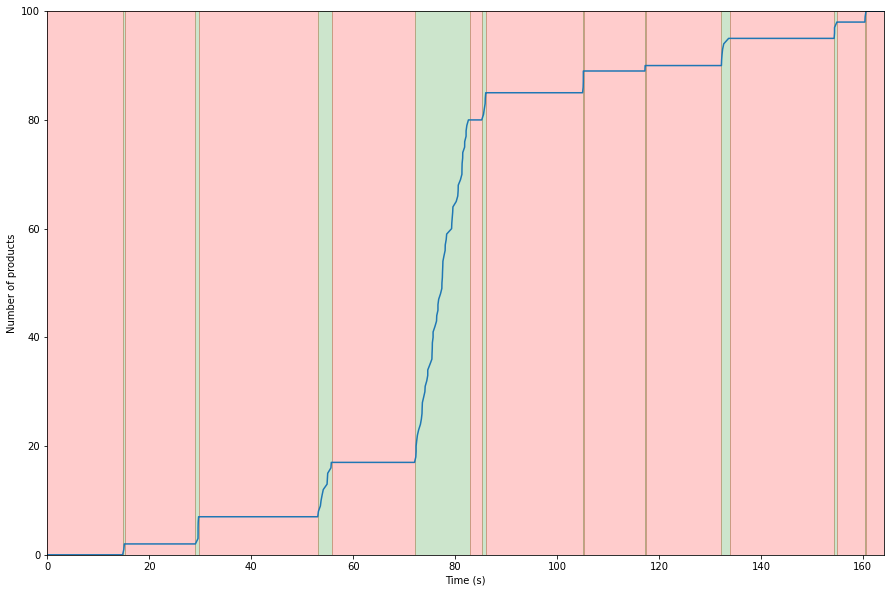

In [29]:
plt.figure(figsize=(15,10))
plt.plot(T, M)
plt.xlabel('Time (s)')
plt.ylabel('Number of products')
plt.xlim(0, T[-1])
plt.ylim(0, MMAX)

indeces = []
for i in range(1, len(O)):
    if O[i-1] != O[i]:
        indeces.append(i)

plt.axvspan(T[0], T[indeces[0]], color='red', alpha=0.2)
colour = 'green'

for i in range(len(indeces)-1):
    plt.axvspan(T[indeces[i]], T[indeces[i+1]], color=colour, alpha=0.2)
    colour = 'green' if colour == 'red' else 'red'
    

plt.axvspan(T[indeces[-1]], T[-1], color=colour, alpha=0.2)
plt.show()
    

### b) Recording the influx of Calcium through individual Voltage gated ion channels

i) Add 4th diffusion reaction

In [30]:
KM_RATE = 5
M_EXTRA = 1.2
MMAX = 100
k_positive = 0.1
k_negative = 0.4
k_d = 0.1

# C = 1 or 0 means channel closed or open, O = 0 or 1 means channel closed or open
C = [1]
O = [0]

# M is the number of products
M = [0]
# T contains the actual time in seconds for each reaction
T = [0]

# chance of opening, closing, calcium going through, calcium diffusing out
propensity_functions = np.array([k_positive * C[0], k_negative * O[0], KM_RATE * M_EXTRA * O[0], k_d * M[0]])

i = 0
# stops if MMAX is reached or 1000s is reached
while M[-1] <= MMAX and T[-1] < 1000:
    reaction, tau = gillepsie(propensity_functions)
    # Opens
    if reaction == 0:
        M.append(M[i])
        C.append(C[i] - 1)
        O.append(O[i] + 1)
    # Closes
    elif reaction == 1:
        M.append(M[i])
        C.append(C[i] + 1)
        O.append(O[i] - 1)
    # Ion passes through channel
    elif reaction == 2:
        M.append(M[i] + 1)
        C.append(C[i])
        O.append(O[i]) 
    # Calcium diffuses out
    else:
        M.append(M[i] - 1)
        C.append(C[i])
        O.append(O[i])

    # update propensity functions
    propensity_functions[0] = k_positive * C[i+1]
    propensity_functions[1] = k_negative * O[i+1]
    propensity_functions[2] = KM_RATE * M_EXTRA * O[i+1]
    propensity_functions[3] = k_d * M[i+1]
    T.append(T[i] + tau)
    i += 1

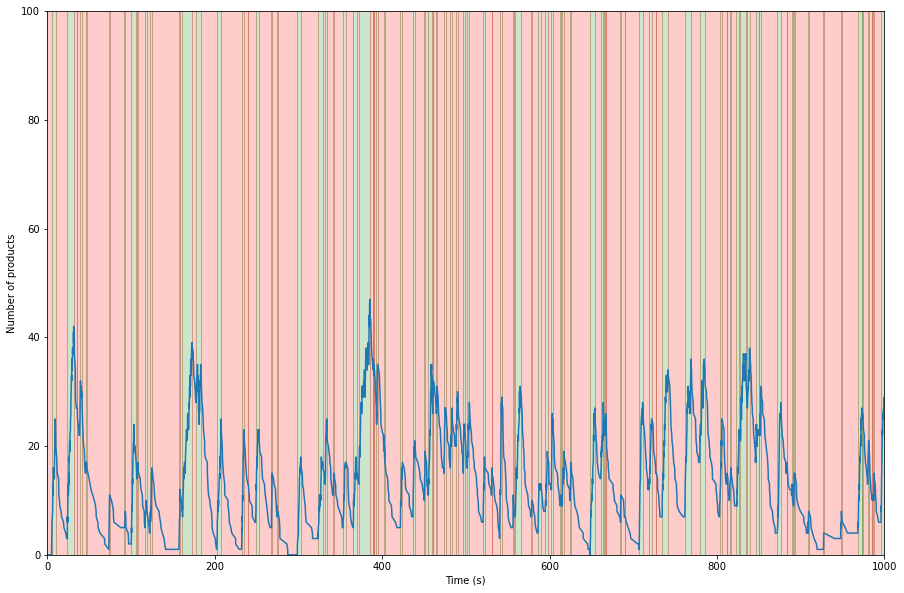

In [31]:
plt.figure(figsize=(15,10))
plt.plot(T, M)
plt.xlabel('Time (s)')
plt.ylabel('Number of products')
plt.xlim(0, T[-1])
plt.ylim(0, MMAX)

indeces = []
for i in range(1, len(O)):
    if O[i-1] != O[i]:
        indeces.append(i)

plt.axvspan(T[0], T[indeces[0]], color='red', alpha=0.2)
colour = 'green'

for i in range(len(indeces)-1):
    plt.axvspan(T[indeces[i]], T[indeces[i+1]], color=colour, alpha=0.2)
    colour = 'green' if colour == 'red' else 'red'
    

plt.axvspan(T[indeces[-1]], T[-1], color=colour, alpha=0.2)
plt.show()

ii) Add activation function for channel opening based on membrane potential.

The dotted black lines indicate when the membrane potential changes from -80 to -15 and then back.

In [43]:
KM_RATE = 5
M_EXTRA = 1.2
MMAX = 100
k_negative = 0.4
k_d = 0.1
resting_potential = -80
membrane_depolarised = -15

def k_p(U): return 0.2 * ((U + 100)**4)/(50**4 + (U+100)**4)


# C = 1 or 0 means channel closed or open, O = 0 or 1 means channel closed or open
C = [1]
O = [0]

# M is the number of products
M = [0]
# T contains the actual time in seconds for each reaction
T = [0]

# chance of opening, closing, calcium going through, calcium diffusing out
propensity_functions = np.array([k_p(resting_potential) * C[0], k_negative * O[0], KM_RATE * M_EXTRA * O[0], k_d * M[0]])

i = 0
# stops if MMAX is reached or 1000s is reached
while M[-1] <= MMAX and T[-1] < 1000:
    reaction, tau = gillepsie(propensity_functions)
    # Opens
    if reaction == 0:
        M.append(M[i])
        C.append(C[i] - 1)
        O.append(O[i] + 1)
    # Closes
    elif reaction == 1:
        M.append(M[i])
        C.append(C[i] + 1)
        O.append(O[i] - 1)
    # Ion passes through channel
    elif reaction == 2:
        M.append(M[i] + 1)
        C.append(C[i])
        O.append(O[i]) 
    # Calcium diffuses out
    else:
        M.append(M[i] - 1)
        C.append(C[i])
        O.append(O[i])

    # update propensity functions (changing membrane potential at chosen times)
    propensity_functions[0] = k_p(resting_potential) * C[i+1] if i < 10 or i > 850 else k_p(membrane_depolarised) * C[i+1]
    propensity_functions[1] = k_negative * O[i+1]
    propensity_functions[2] = KM_RATE * M_EXTRA * O[i+1]
    propensity_functions[3] = k_d * M[i+1]
    T.append(T[i] + tau)
    i += 1

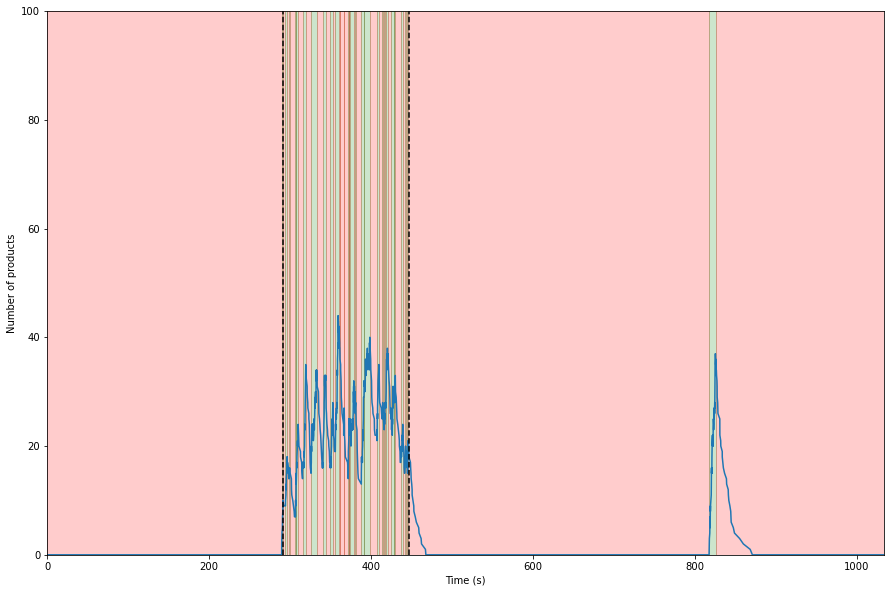

In [44]:
plt.figure(figsize=(15,10))
plt.plot(T, M)
plt.xlabel('Time (s)')
plt.ylabel('Number of products')
plt.xlim(0, T[-1])
plt.ylim(0, MMAX)

indeces = []
for i in range(1, len(O)):
    if O[i-1] != O[i]:
        indeces.append(i)

plt.axvspan(T[0], T[indeces[0]], color='red', alpha=0.2)
colour = 'green'

for i in range(len(indeces)-1):
    plt.axvspan(T[indeces[i]], T[indeces[i+1]], color=colour, alpha=0.2)
    colour = 'green' if colour == 'red' else 'red'
    

plt.axvspan(T[indeces[-1]], T[-1], color=colour, alpha=0.2)
plt.axvline(x=T[10], color='black', linestyle='--')
plt.axvline(x=T[850], color='black', linestyle='--')
plt.show()

## Task 3

Simulation model of the Kai Cyanobacterial Clock

First we initialise the parameters.

In [16]:
UT = (0, 0.479077)
TD = (0, 0.212923)
SD = (0, 0.505692)
US = (0, 0.0532308)
TU = (0.21, 0.0798462)
DT = (0, 0.173)
DS = (0.31, -0.319385)
SU = (0.11, -0.133077)

KaiA = 1.3
K = 0.43

T_0 = 0.68
D_0 = 1.36
S_0 = 0.34
U_0 = 3.4 - T_0 - D_0 - S_0

In [17]:
from scipy.integrate import solve_ivp

def k(i,S): return i[0] + ((i[1] * A(S)) / (K + A(S)))
def A(S): return max(0, KaiA - 2*S)

We then define our system of differential equations.

In [18]:
def ODEs(t, y):
    T, D, S = y[0], y[1], y[2]
    U = 3.4 - T - D - S
    dT = k(UT, S) * U + k(DT, S) * D - k(TU, S) * T - k(TD, S) * T
    dD = k(TD, S) * T + k(SD, S) * S - k(DT, S) * D - k(DS, S) * D
    dS = k(US, S) * U + k(DS, S) * D - k(SU, S) * S - k(SD, S) * S 
    dU = k(TU, S) * T + k(SU, S) * S - k(US, S) * U - k(UT, S) * U
    return [dT, dD, dS, dU]

We solve this system.

In [19]:
sol = solve_ivp(ODEs, [0, 100], [T_0, D_0, S_0, U_0])

A_1 = np.array([max(0, 1.3 - 2*sol.y[2][i]) for i in range(len(sol.t))])

We plot the results.

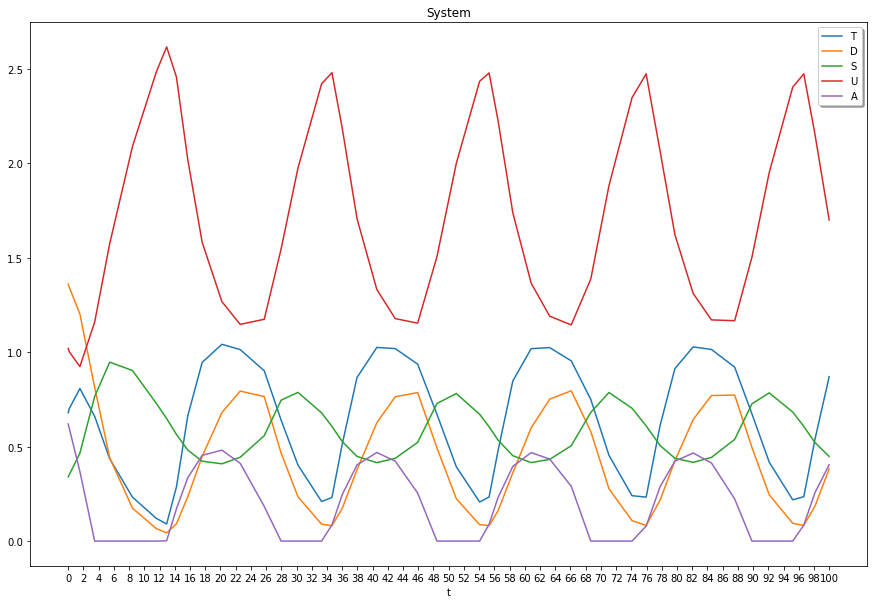

In [20]:
plt.figure(figsize=(15,10))
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[2])
plt.plot(sol.t, sol.y[3])
plt.plot(sol.t, A_1)

plt.xlabel('t')
plt.legend(['T', 'D', 'S', 'U', 'A'], shadow=True)
plt.title('System')
plt.xticks(np.arange(0, 101, step=2))
plt.show()